In [2]:
import sys
from pathlib import Path 
from torchvision.transforms import v2
import torch
import matplotlib.pyplot as plt
modulepath = Path.cwd().parent / "utils"
modulepath = str(modulepath)
projectpath = Path.cwd().parent
projectpath = str(projectpath)
if modulepath not in sys.path:
    sys.path.insert(0,str(modulepath))
if projectpath not in sys.path:
    sys.path.insert(0,str(projectpath))  
print(sys.path)


['c:\\Users\\oriol\\GitHub_Repos\\CNN-classification', 'c:\\Users\\oriol\\GitHub_Repos\\CNN-classification\\utils', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch\\python312.zip', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch\\DLLs', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch\\Lib', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch', '', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch\\Lib\\site-packages', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch\\Lib\\site-packages\\win32', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch\\Lib\\site-packages\\Pythonwin']


In [3]:
from utils.data_loaders import create_train_test_dataloaders
transform = v2.Compose([v2.RandomCrop(size=(20, 20))])#,v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])


In [4]:
train_basic,test_basic = create_train_test_dataloaders("FashionMNIST")
train_augmented,test_augmented = create_train_test_dataloaders("FashionMNIST",transform=transform)
img_basic,label_basic = next(iter(train_basic))
img_augmented,label_augmented = next(iter(train_augmented))

(np.float64(-0.5), np.float64(19.5), np.float64(19.5), np.float64(-0.5))

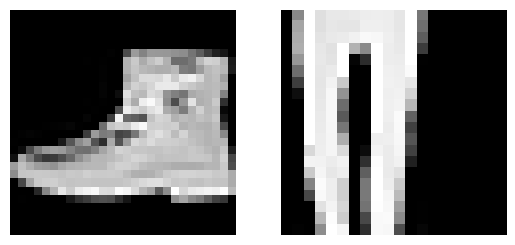

In [5]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(img_basic[0].permute(1,2,0),cmap="gray")
ax[1].imshow(img_augmented[0].permute(1,2,0),cmap="gray")
ax[0].axis(False)
ax[1].axis(False)

In [6]:
img_basic.shape

torch.Size([32, 1, 28, 28])

In [8]:
from utils.model_architectures import TinyVGG
from torchinfo import summary 

tvgg = TinyVGG(1,20,10)

In [7]:
summary(tvgg,input_size=[32,1,28,28])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 10]                  --
├─Sequential: 1-1                        [32, 20, 12, 12]          --
│    └─Conv2d: 2-1                       [32, 20, 26, 26]          200
│    └─ReLU: 2-2                         [32, 20, 26, 26]          --
│    └─Conv2d: 2-3                       [32, 20, 24, 24]          3,620
│    └─ReLU: 2-4                         [32, 20, 24, 24]          --
│    └─MaxPool2d: 2-5                    [32, 20, 12, 12]          --
├─Sequential: 1-2                        [32, 20, 4, 4]            --
│    └─Conv2d: 2-6                       [32, 20, 10, 10]          3,620
│    └─ReLU: 2-7                         [32, 20, 10, 10]          --
│    └─Conv2d: 2-8                       [32, 20, 8, 8]            3,620
│    └─ReLU: 2-9                         [32, 20, 8, 8]            --
│    └─MaxPool2d: 2-10                   [32, 20, 4, 4]            --
├─Seq

In [9]:
tvgg.cpu()
tvgg.forward(img_basic[0].unsqueeze(dim=0))
torch.softmax(tvgg.forward(img_basic[0].unsqueeze(dim=0)),1)

#next(tvgg.parameters()).is_cuda #check if model on cuda

tensor([[0.1114, 0.1015, 0.0978, 0.0961, 0.1002, 0.0979, 0.0974, 0.1039, 0.0959,
         0.0980]], grad_fn=<SoftmaxBackward0>)

In [ ]:
from utils.train import train

#First change how I import tensorboard

from utils.model_architectures import TinyVGG
from utils.data_loaders import create_train_test_dataloaders
from utils.config import device 
from torch import nn
train_dataloader, test_dataloader = create_train_test_dataloaders()

model_0 = TinyVGG(input_shape=1,hidden_channels=10,output_shape=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.01)

train(model=model_0,train_dataloader=train_dataloader,test_dataloader=test_dataloader,optimizer=optimizer,loss_fn=loss_fn,epochs=1,writer=None)


c:\Users\oriol\anaconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AttributeError: module 'torch.utils' has no attribute 'tensorboard'